In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
warnings.filterwarnings('ignore')

In [2]:
"""
loss,
learning_rate,
max_depth
max_leaf_nodes
max_iter
l2_regularization
random_state
early_stopping
class_weight
categorical_features
"""

class CFG:
    TRAIN_PATH = "./binary_classification/train.csv"
    TEST_PATH = "./binary_classification/test.csv"
    PREDICT_PATH = "./binary_classification/sample_submission.csv"
    seed = 42
    n_folds = 10
    basic_param = {
        'loss': 'log_loss',
        'learning_rate': 1e-2,
        'max_depth': 10,
        'max_leaf_nodes': 63,
        'max_iter': 1000,
        'l2_regularization': 1e-2,
        'random_state': seed,
        'early_stopping': True,
        'class_weight': 'balanced',
        'categorical_features': []
    }
    best_param = {
        'loss': 'log_loss',
        'max_leaf_nodes': 255,
        'max_iter': 2000,
        'max_depth': 15,
        'learning_rate': 0.2,
        'l2_regularization': 0,
        'random_state': seed,
        'early_stopping': True,
        'class_weight': 'balanced',
        'categorical_features': []
    }
    cols_to_drop = [
        "fold",
        "Class",
        "Skewness",
        "Mean_DMSNR_Curve",
        "id"
    ]

cfg = CFG()

In [3]:
""" load the train dataframe
"""

train = pd.read_csv(cfg.TRAIN_PATH)
train

,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512,0
1,1,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251,0
2,2,112.640625,39.818393,0.379639,0.922306,2.730769,15.689690,8.193471,85.649785,0
3,3,120.679688,45.918448,-0.098490,0.011775,2.696488,20.954662,8.183874,70.332899,0
4,4,134.070312,57.720107,-0.107772,-0.573335,1.107860,11.255051,16.107748,308.753765,0
...,...,...,...,...,...,...,...,...,...,...
117559,117559,132.843750,56.748838,-0.060070,-0.554084,4.054348,27.844144,6.564423,44.442664,0
117560,117560,112.578125,52.539271,0.179580,-0.306961,1.637960,15.331913,11.384718,142.535470,0
117561,117561,119.757812,49.980013,0.064402,-0.270822,3.877926,19.788559,6.959740,56.367789,0
117562,117562,105.789062,46.986595,0.441426,0.372466,2.097826,17.170612,9.442445,99.074539,0


In [4]:
""" check the basic statistic of train

제거 대상: 균일 분포에 가까운 컬럼
"""

train.info(), train.describe() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117564 entries, 0 to 117563
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    117564 non-null  int64  
 1   Mean_Integrated       117564 non-null  float64
 2   SD                    117564 non-null  float64
 3   EK                    117564 non-null  float64
 4   Skewness              117564 non-null  float64
 5   Mean_DMSNR_Curve      117564 non-null  float64
 6   SD_DMSNR_Curve        117564 non-null  float64
 7   EK_DMSNR_Curve        117564 non-null  float64
 8   Skewness_DMSNR_Curve  117564 non-null  float64
 9   Class                 117564 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 9.0 MB


(None,
                   id  Mean_Integrated             SD             EK  \
 count  117564.000000    117564.000000  117564.000000  117564.000000   
 mean    58781.500000       111.248300      46.713535       0.503498   
 std     33937.947861        24.906474       6.102941       1.127093   
 min         0.000000         6.054688      24.783273      -1.730782   
 25%     29390.750000       104.546875      43.443390       0.049761   
 50%     58781.500000       116.664062      47.478932       0.186498   
 75%     88172.250000       126.296875      50.862718       0.395620   
 max    117563.000000       189.367188      93.602933       7.879628   
 
             Skewness  Mean_DMSNR_Curve  SD_DMSNR_Curve  EK_DMSNR_Curve  \
 count  117564.000000     117564.000000   117564.000000   117564.000000   
 mean        1.886385         11.962921       26.190678        8.037488   
 std         6.515466         26.719946       20.041937        3.840980   
 min        -1.791886          0.213211    

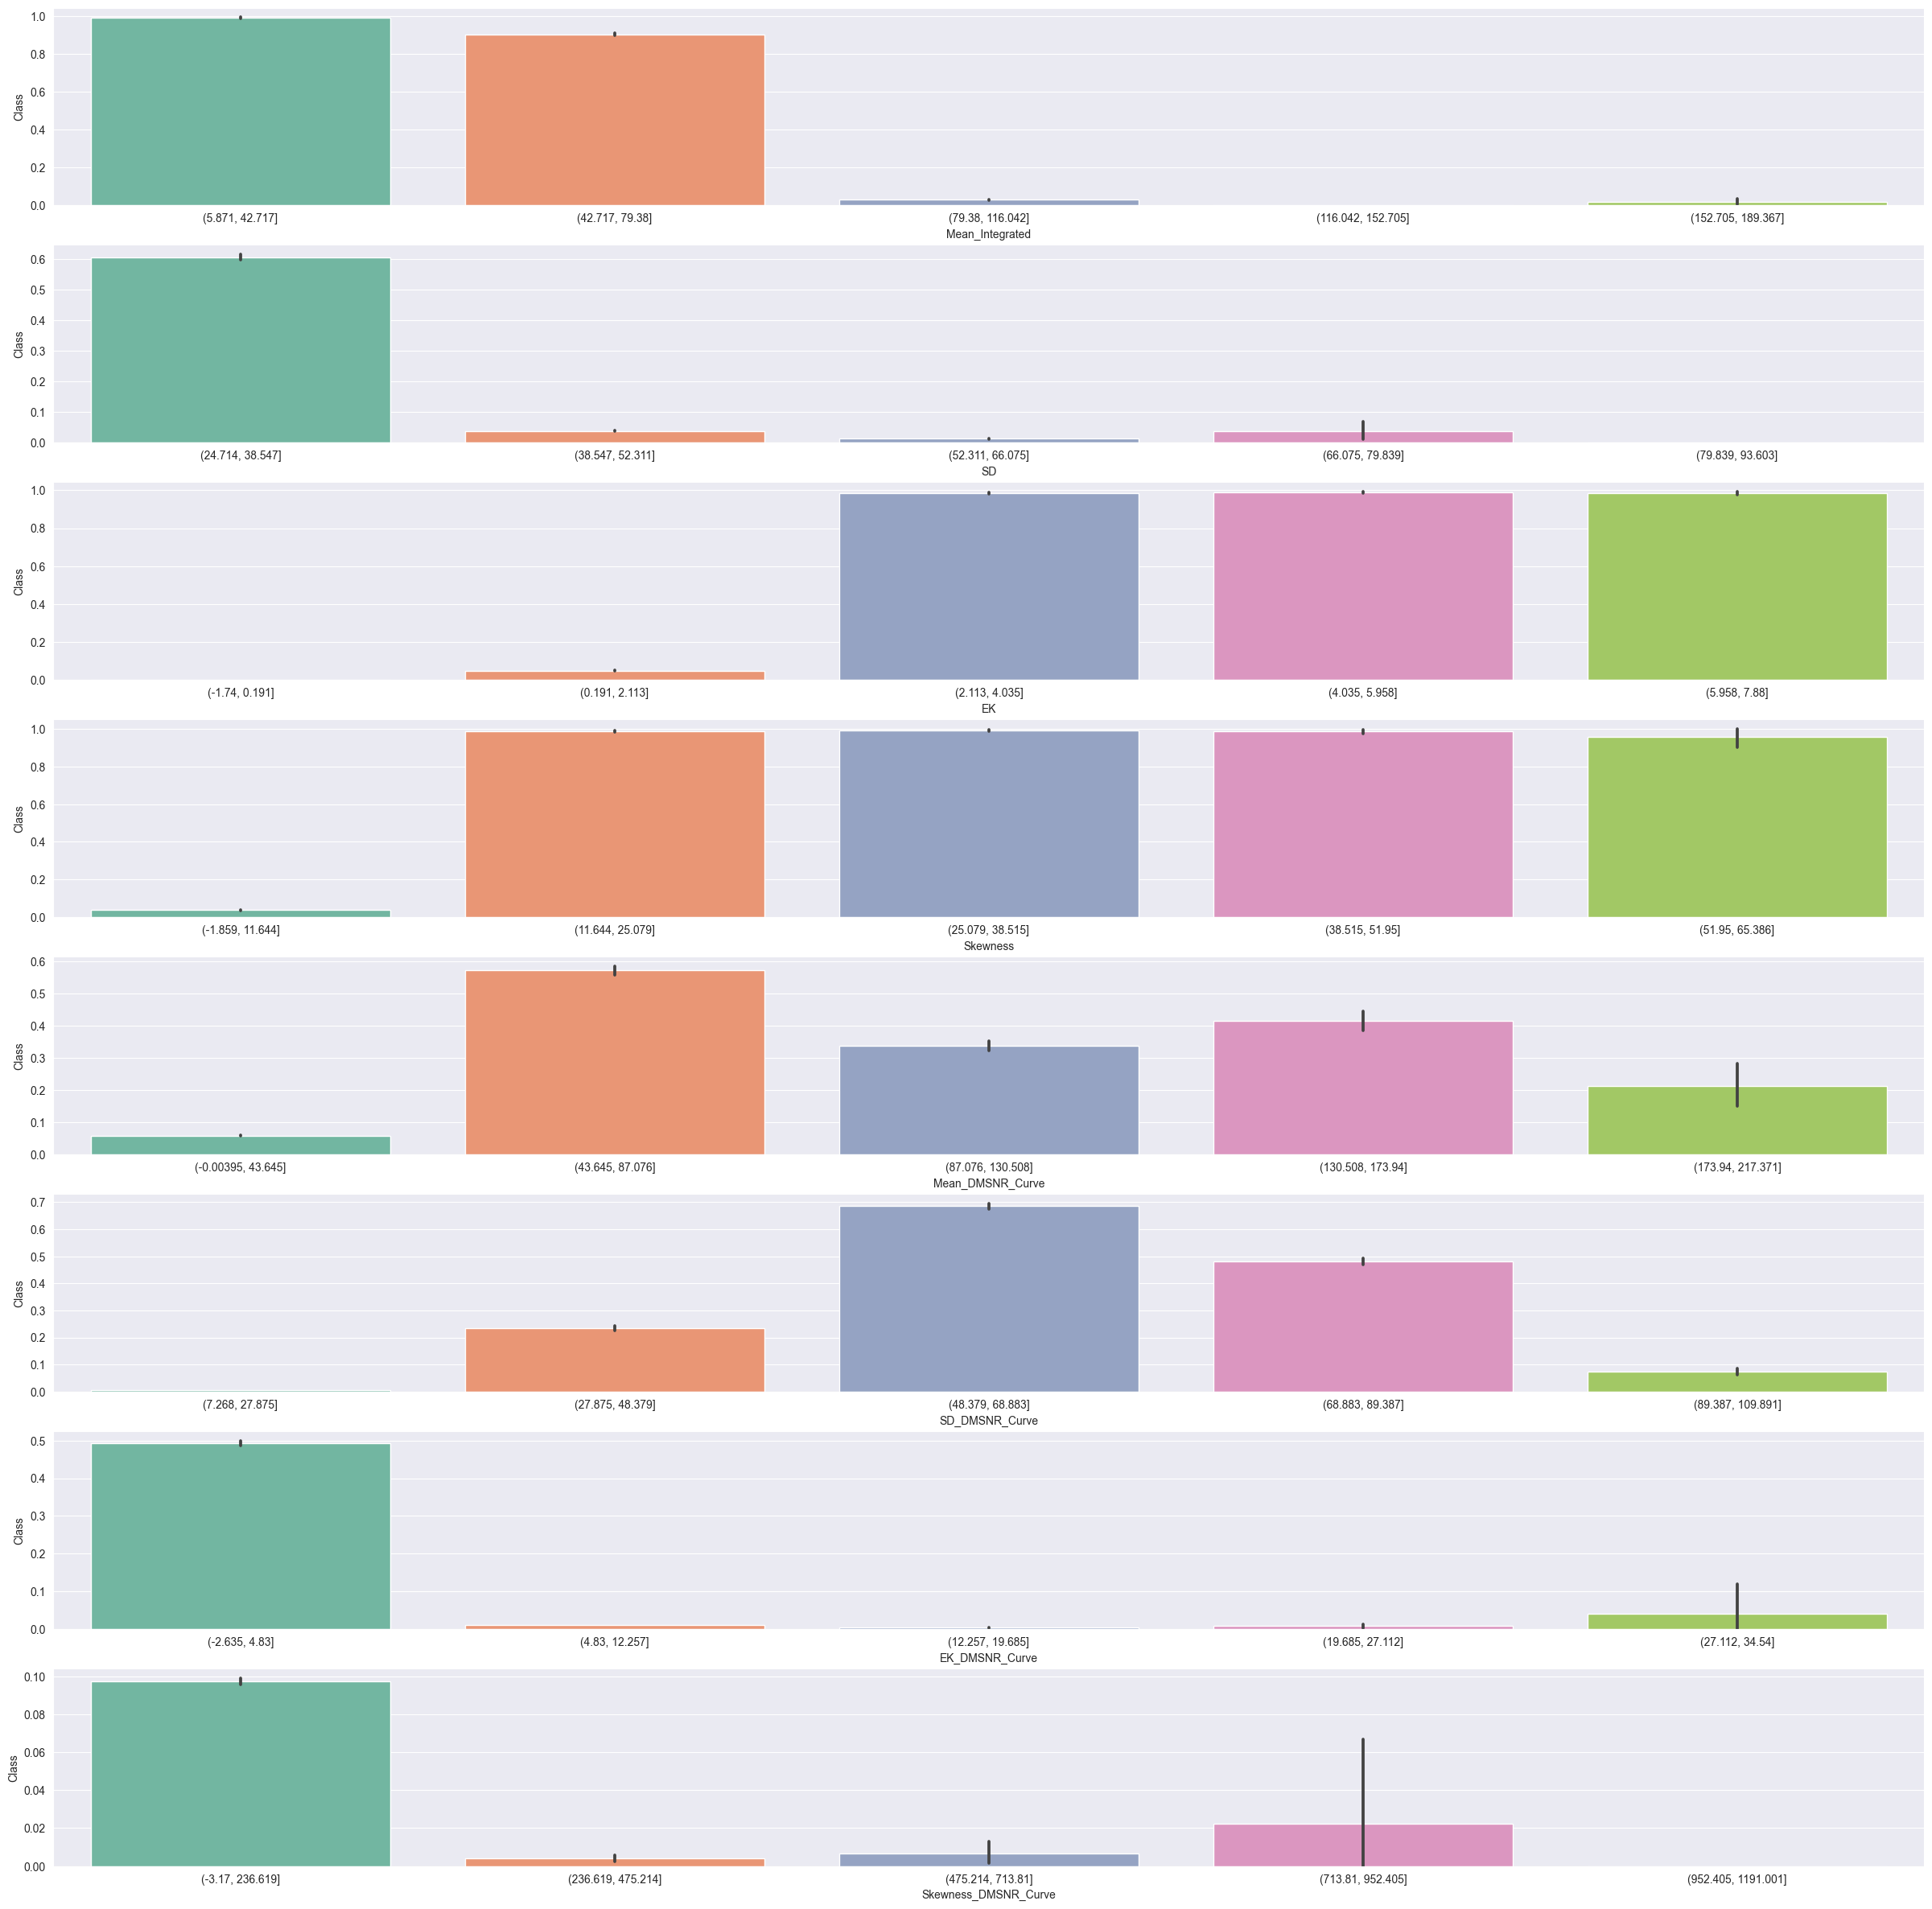

In [5]:
""" do the basic feature selection: manpower of feature

selection 기준:
     1) 분산이 크면서, 통계적 유의성 있어야
"""
def visualize_categorical_empower(df: pd.DataFrame, features: list[str], label: str, n_row: int, n_col: int) -> None:
    plt.figure(figsize=(30,30))
    grid = gridspec.GridSpec(n_row, n_col)
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    
    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx])
        sns.barplot(data=df, x=feature, y=label, ax=ax, palette="Set2")


def visualize_continuous_empower(df: pd.DataFrame, features: list[str], label: str, n_row: int, n_col: int) -> None:
    copied_df = df.copy()
    plt.figure(figsize=(30,30))
    grid = gridspec.GridSpec(n_row, n_col)
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    
    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx])
        copied_df[feature] = pd.cut(df[feature], bins=5)
        sns.barplot(data=copied_df, x=feature, y=label, ax=ax, palette="Set2")
        

categorical_features = ['']
continuous_features = list(train.columns[1:-1])
visualize_continuous_empower(
    train,
    continuous_features,
    "Class",
    len(continuous_features),
    1
)

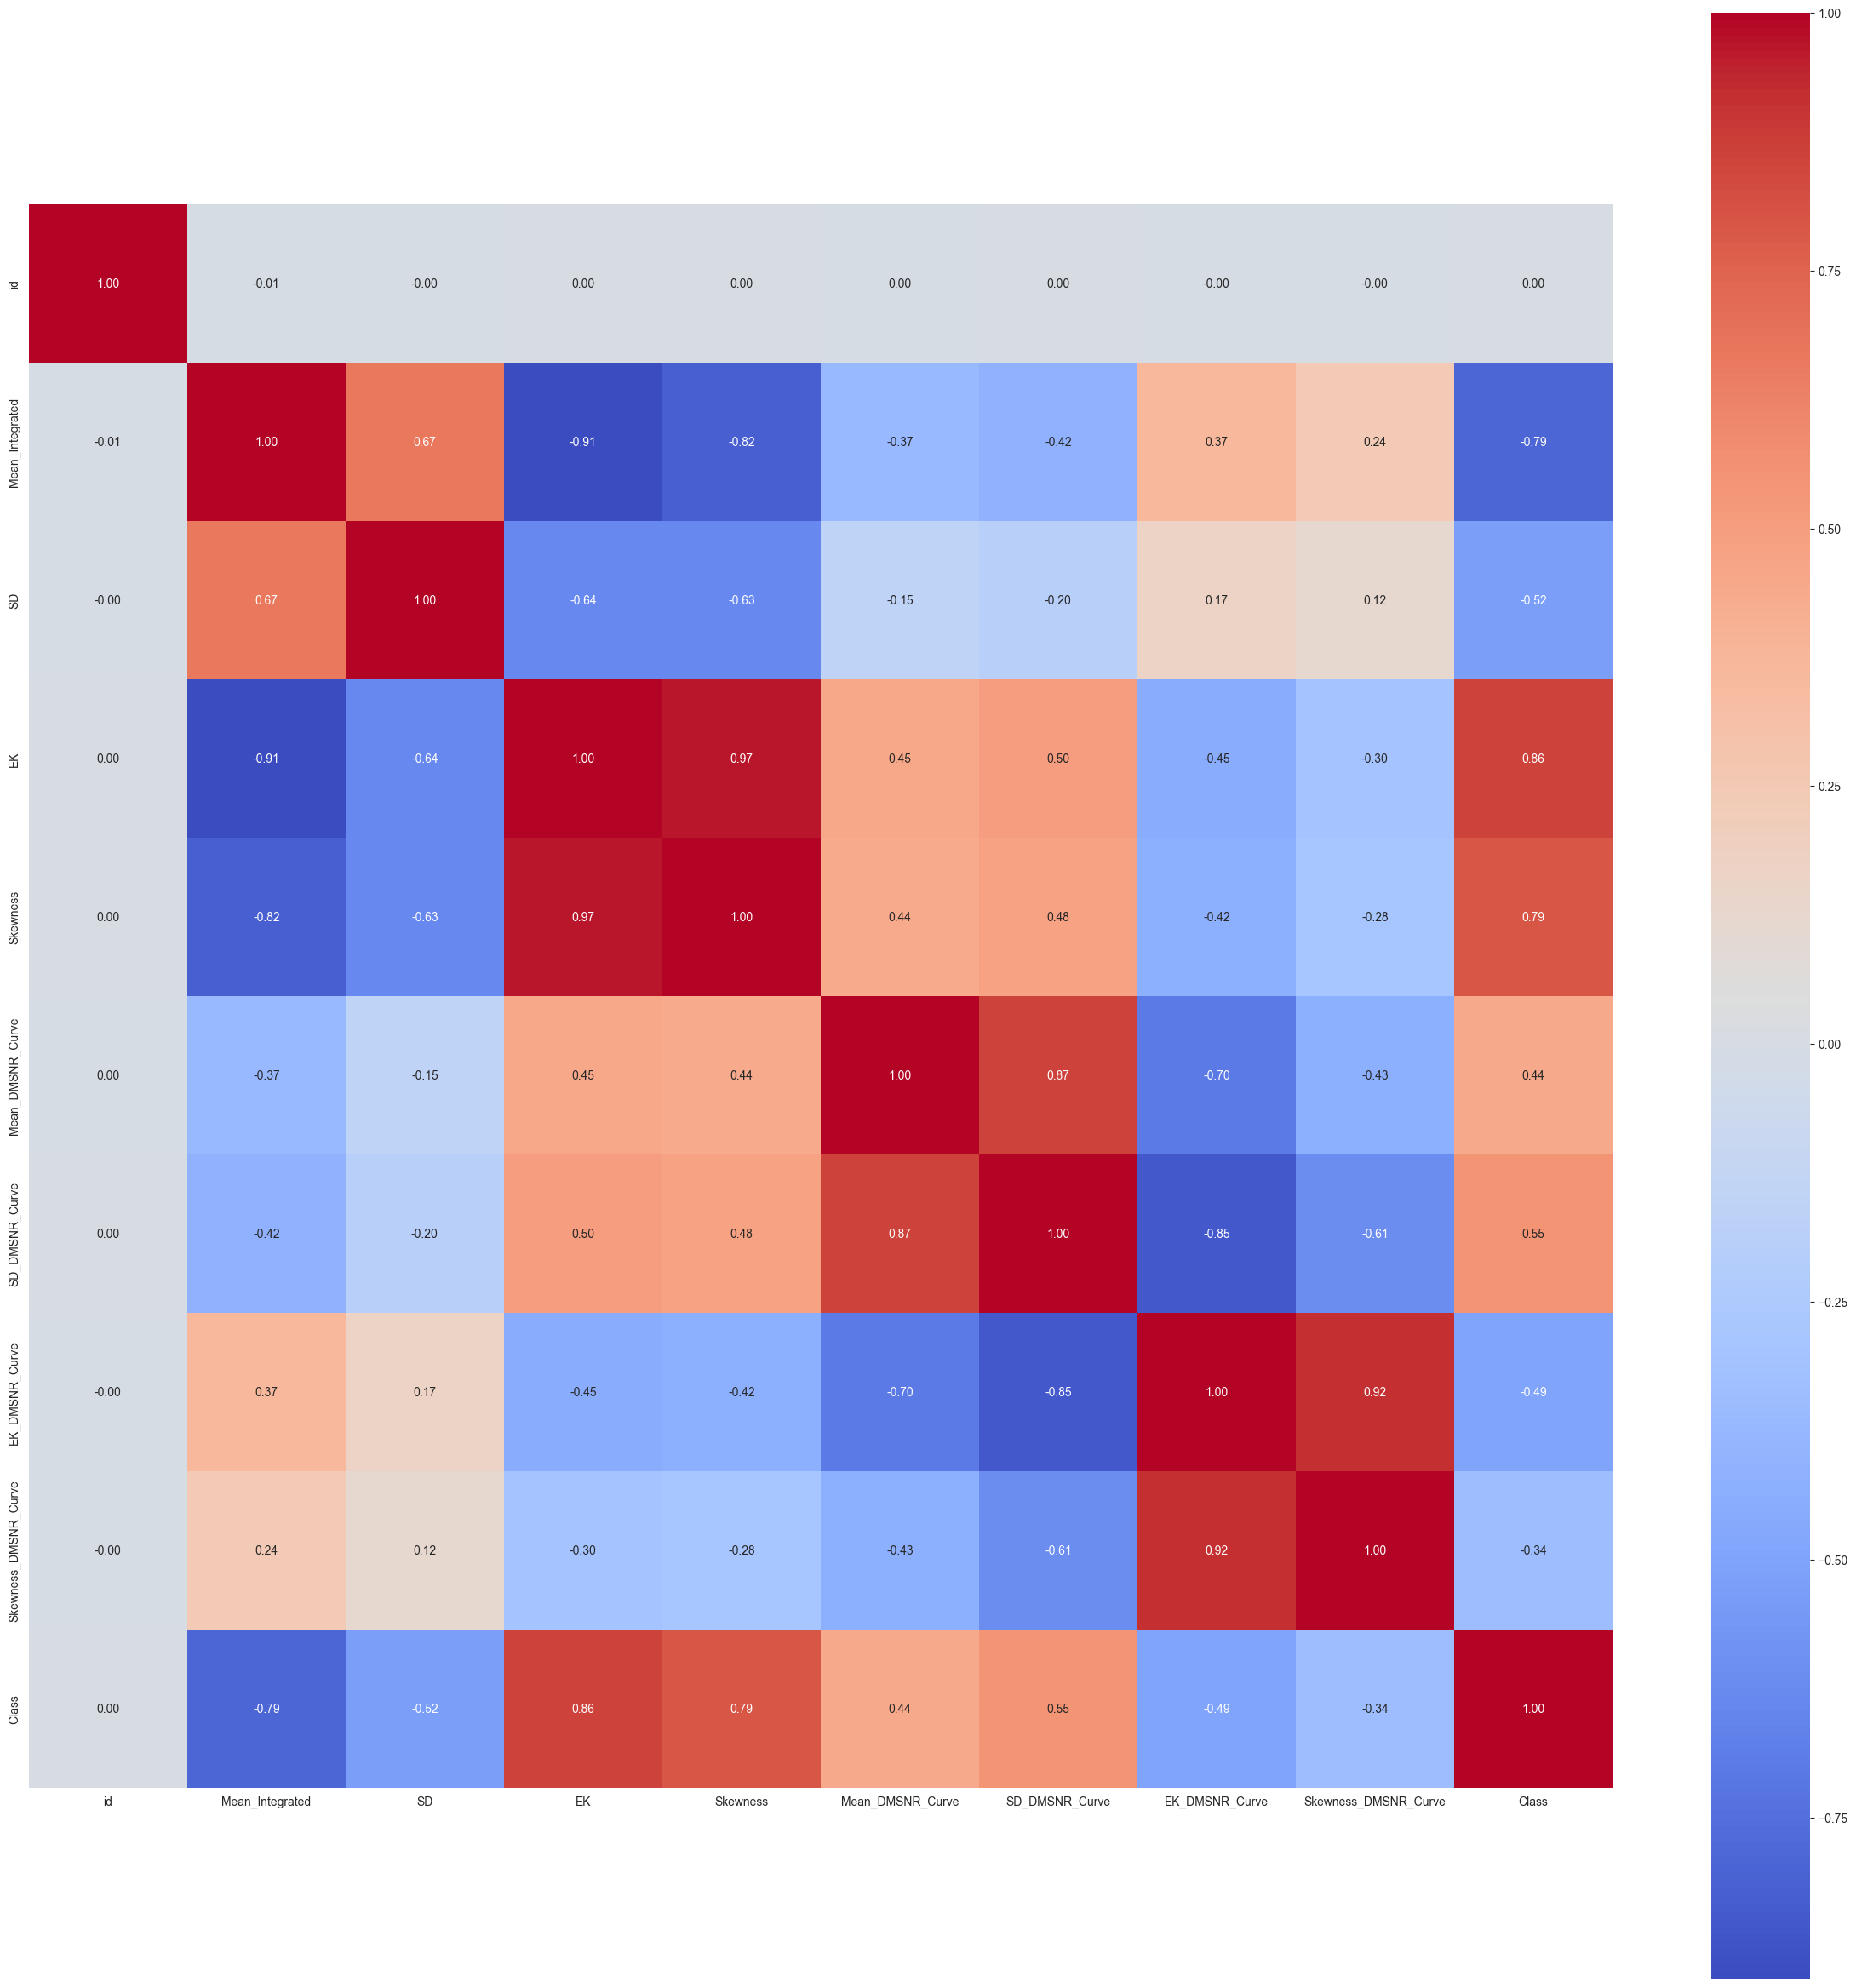

In [6]:
""" do the basic feature selection: co-relation

selection 기준: 타켓 클래스와 0.5 이상

제거 대상:
"Skewness_DMSNR_Curve",
"EK_DMSNR_Curve",
"Mean_DMSNR_Curve"
"""
def visualize_correlation(df: pd.DataFrame) -> None:
    plt.figure(figsize=(30, 30))
    sns.heatmap(
        df.corr(),
        xticklabels=df.columns,
        yticklabels=df.columns,
        annot=True,
        square=True,
        cmap="coolwarm",
        fmt=".2f"
    )
    plt.show()
    return

visualize_correlation(train)

In [7]:
""" do the basic feature selection: mutual information

제거 대상: 0.15 이하 컬럼

"id"
"SD"
"""

mutual_info_classif(
    X=train.drop(columns=['id', 'Class']),
    y=train.Class,
    random_state=cfg.seed
)

array([0.25125378, 0.1443985 , 0.26984457, 0.25136328, 0.17505032,
       0.18242325, 0.17499807, 0.18485426])

In [19]:
""" do the basic feature selection: feature importance 
"""


estimator = HistGradientBoostingClassifier(**cfg.basic_param).fit(train.drop(columns=['Class', 'id']), train.Class)
result = permutation_importance(
    estimator,
    X=train.drop(columns=['Class', 'id']),
    y=train.Class
)
result.importances_mean

array([ 0.00222517,  0.00865061,  0.15833078,  0.00092035, -0.000427  ,
        0.01292232,  0.00261304,  0.00253819])

In [8]:
""" apply the cv strategy """


cv = StratifiedKFold(
    n_splits=cfg.n_folds,
    random_state=cfg.seed,
    shuffle=True
)
train["fold"] = -1
for num, (tx, vx) in enumerate(cv.split(X=train, y=train.Class)):
    train.loc[vx, "fold"] = int(num)

train

,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class,fold
0,0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512,0,8
1,1,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251,0,8
2,2,112.640625,39.818393,0.379639,0.922306,2.730769,15.689690,8.193471,85.649785,0,0
3,3,120.679688,45.918448,-0.098490,0.011775,2.696488,20.954662,8.183874,70.332899,0,9
4,4,134.070312,57.720107,-0.107772,-0.573335,1.107860,11.255051,16.107748,308.753765,0,8
...,...,...,...,...,...,...,...,...,...,...,...
117559,117559,132.843750,56.748838,-0.060070,-0.554084,4.054348,27.844144,6.564423,44.442664,0,5
117560,117560,112.578125,52.539271,0.179580,-0.306961,1.637960,15.331913,11.384718,142.535470,0,7
117561,117561,119.757812,49.980013,0.064402,-0.270822,3.877926,19.788559,6.959740,56.367789,0,9
117562,117562,105.789062,46.986595,0.441426,0.372466,2.097826,17.170612,9.442445,99.074539,0,0


In [9]:
""" check the cv result
"""
train.fold.value_counts()

0    11757
2    11757
3    11757
1    11757
8    11756
9    11756
4    11756
6    11756
5    11756
7    11756
Name: fold, dtype: int64

In [10]:
""" optimizing the hyper-param of model """

tuning_X, tuning_Y = train.drop(columns=cfg.cols_to_drop), train.Class

param_dist = {
    'learning_rate': [1e-3, 1e-2, 1e-1, 0.2, 0.3],
    'max_depth': [5, 10, 15, 20],
    'max_iter': [500, 1000, 1500, 2000],
    'max_leaf_nodes': [31, 63, 127, 255],
    'l2_regularization': [0, 1e-2, 1e-1, 1e-3],
}

tuning_model = HistGradientBoostingClassifier(**cfg.basic_param)
random_search = RandomizedSearchCV(
    estimator=tuning_model,
    param_distributions=param_dist,
    n_iter=50,  # 탐색할 하이퍼파라미터 조합 수
    scoring='f1',  # 적절한 평가 지표로 설정
    cv=10,  # 교차 검증 횟수
    random_state=cfg.seed,
    n_jobs=-1
)
random_search.fit(tuning_X, tuning_Y)
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Hyperparameters: {'max_leaf_nodes': 255, 'max_iter': 2000, 'max_depth': 15, 'learning_rate': 0.2, 'l2_regularization': 0}
Best Score: 0.9354948381922128


In [11]:
""" train/validation pipeline with oof
"""


oof = []
oof_metric = {
    'log_loss': [],
    'f1': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
}
metric_fn = {
    'log_loss': log_loss,
    'f1': f1_score,
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
}
for fold in range(cfg.n_folds):
    train_df = train[train["fold"] != fold]
    valid_df = train[train["fold"] == fold]
    
    train_X, train_Y = train_df.drop(columns=cfg.cols_to_drop), train_df.Class
    valid_X, valid_Y = valid_df.drop(columns=cfg.cols_to_drop), valid_df.Class
    
    # train
    model = HistGradientBoostingClassifier(**cfg.best_param).fit(train_X, train_Y)
    oof.append(model)
    print(f"train log loss is: {log_loss(train_Y, model.predict_proba(train_X))}")
    
    # validation    
    valid_pred = model.predict(valid_X)
    valid_pred_prob = model.predict_proba(valid_X)
    for k, metric in metric_fn.items():
        if k == "log_loss":
            oof_metric[k].append(metric(valid_Y, valid_pred_prob)) 
        else:
            oof_metric[k].append(metric(valid_Y, valid_pred))

# calculate cv
for k, metric in oof_metric.items():
    v = sum(oof_metric[k]) / cfg.n_folds
    print(f"oof {k} is: {v}")

train log loss is: 0.020628445133406396
train log loss is: 0.01750629392126282
train log loss is: 0.019860409327801722
train log loss is: 0.020807023551824403
train log loss is: 0.022064900799403063
train log loss is: 0.02149042262699809
train log loss is: 0.02134003316282097
train log loss is: 0.018635502688401914
train log loss is: 0.023264775903332948
train log loss is: 0.019534209823793783
oof log_loss is: 0.041635461270987925
oof f1 is: 0.9363347502378877
oof accuracy is: 0.9878959283318665
oof precision is: 0.9196042258893478
oof recall is: 0.9537705687042963


In [12]:
""" prediction pipeline with oof
"""


test_cols_to_drop = [
        "Skewness",
        "Mean_DMSNR_Curve",
        "id"
    ]
test_df = pd.read_csv(cfg.TEST_PATH)
submission_df = pd.read_csv(cfg.PREDICT_PATH)

# oof prediction
oof_preds = []
for oof_model in oof:
    test_X = test_df.drop(columns=test_cols_to_drop)
    oof_preds.append(oof_model.predict_proba(test_X))

# get oof prediction
# preds = np.mean(oof_preds, axis=0).argmax(axis=1)
mean_preds = np.mean(oof_preds, axis=0)
preds_index = mean_preds.argmax(axis=1)
preds = 1 - mean_preds[np.arange(mean_preds.shape[0]), preds_index]
preds

array([0.0013461 , 0.00188698, 0.00133619, ..., 0.00134834, 0.07058974,
       0.00193328])

In [16]:
# preds = [1 - i[j] for i,j in zip(mean_preds, preds_index)]
# preds

[0.0033102277200374175,
 0.005557419119686435,
 0.003203958888406633,
 0.2565081935938317,
 0.0282027033167489,
 0.003840285238468466,
 0.003203958888406633,
 0.030263979561922838,
 0.022770478070443856,
 0.003664120234910029,
 0.004669221579587712,
 0.12882192115109725,
 0.043870764051529454,
 0.10553688160640162,
 0.003203958888406633,
 0.012720770164654227,
 0.01724069132918038,
 0.004056014194638302,
 0.056401711436958046,
 0.009662185500316056,
 0.003203790985621291,
 0.020854150296625185,
 0.0033617005663574284,
 0.06203780174974882,
 0.2401994970697786,
 0.003203958888406633,
 0.003840285238468466,
 0.003203958888406633,
 0.004562724179488109,
 0.004477443456222141,
 0.009249009629177407,
 0.13971224509569014,
 0.004335987028764365,
 0.003203790985621291,
 0.003209551770314234,
 0.003953322768008527,
 0.003840285238468466,
 0.005836712468742178,
 0.034057638124871614,
 0.0032034001387227784,
 0.0032030055705460914,
 0.0036931046733581496,
 0.009159255424480484,
 0.41145211802285

In [13]:
# make the submission dataframe

submission_df["Class"] = preds
submission_df

,id,Class
0,117564,0.001346
1,117565,0.001887
2,117566,0.001336
3,117567,0.227017
4,117568,0.002545
...,...,...
78372,195936,0.001365
78373,195937,0.001349
78374,195938,0.001348
78375,195939,0.070590
